# 0.load Moudle

In [ ]:
import os
import pickle as pkl
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1.load data

In [ ]:
counts_df = pd.read_csv("/mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/raw_count_peak.csv", index_col=0)
counts_df

In [ ]:
counts_df.set_index('peak', inplace=True)
counts_df

In [ ]:
counts_df = counts_df.iloc[:, 3:9]
counts_df

,B21-1A.V11,B21-2A.V11,B21-3A.V11,S21-1A.V11,S21-2A.V11,S21-3A.V11
peak,,,,,,
S21-2A_FKDL190740156-1a_peak_121b,112,140,122,110,143,87
S21-2A_FKDL190740156-1a_peak_132,180,253,290,215,393,201
T21-2A_FKDL190740162-1a_peak_148b,47,63,92,62,69,32
T21-3A_FKDL190740163-1a_peak_86,86,73,108,79,84,89
S21-2A_FKDL190740156-1a_peak_168,104,133,181,112,168,80
...,...,...,...,...,...,...
S21-1A_FKDL190740155-1a_peak_675515,58,52,58,106,66,38
S21-1A_FKDL190740155-1a_peak_675516,68,46,58,142,114,48
S21-1A_FKDL190740155-1a_peak_675518,64,32,59,142,80,50


In [ ]:
counts_df = counts_df.T
counts_df

In [ ]:
metadata = pd.DataFrame({
    'condition': ['BLM'] * 3 + ['PBS'] * 3,
}, index=counts_df.index)
metadata

,condition
B21-1A.V11,BLM
B21-2A.V11,BLM
B21-3A.V11,BLM
S21-1A.V11,PBS
S21-2A.V11,PBS
S21-3A.V11,PBS


# 2.DESeq2

## 2.1 Build DESeq2 object

In [ ]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)

## 2.2 vst

In [ ]:
dds.vst(use_design=True)
dds

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 1.80 seconds.

Fitting dispersion trend curve...
... done in 0.54 seconds.



AnnData object with n_obs × n_vars = 6 × 34276
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type'
    obsm: 'design_matrix', 'size_factors'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions'
    layers: 'normed_counts', '_mu_hat', 'vst_counts'

In [ ]:
data=dds.layers['vst_counts']

## 2.3 PCA

In [ ]:
# # construct a dataframe using pandas
# df1=pd.DataFrame(data['data'],columns=data['feature_names'])
 
# # Scale data before applying PCA
# scaling=StandardScaler()
 
# # Use fit and transform method 
# scaling.fit(df1)
# Scaled_data=scaling.transform(df1)
 
# Set the n_components=3
principal=PCA(n_components=3)
principal.fit(data)
x=principal.transform(data)
 
# Check the dimensions of data after PCA
print(x.shape)

(6, 3)


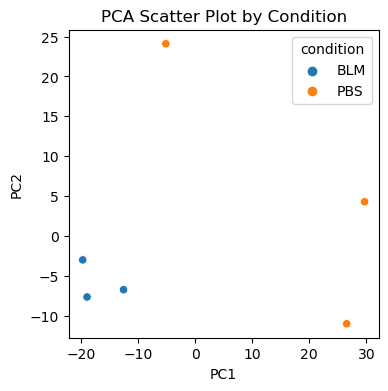

In [ ]:

import seaborn as sns
plt.figure(figsize=(4,4))
sns.scatterplot(x = x[:,0], y = x[:,1], hue=metadata['condition'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatter Plot by Condition')
plt.savefig('atac_pca_plot.pdf', bbox_inches='tight')

## 2.4 DESeq2

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.71 seconds.

Fitting dispersion trend curve...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 1.85 seconds.

Fitting LFCs...
... done in 1.23 seconds.

Replacing 0 outlier genes.



In [ ]:
print(dds)

AnnData object with n_obs × n_vars = 6 × 34276
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'vst_counts', '_mu_LFC', '_hat_diagonals', 'cooks'


In [ ]:
stat_res = DeseqStats(dds, inference=inference, contrast=["condition", "BLM", "PBS"])

In [ ]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition BLM vs PBS
                                       baseMean  log2FoldChange     lfcSE  \
peak                                                                        
S21-2A_FKDL190740156-1a_peak_121b    117.813587        0.020574  0.220373   
S21-2A_FKDL190740156-1a_peak_132     247.944432       -0.274061  0.179765   
T21-2A_FKDL190740162-1a_peak_148b     59.203391        0.152699  0.303292   
T21-3A_FKDL190740163-1a_peak_86       86.677245       -0.063211  0.253762   
S21-2A_FKDL190740156-1a_peak_168     125.689001        0.086786  0.223392   
...                                         ...             ...       ...   
S21-1A_FKDL190740155-1a_peak_675515   64.786479       -0.483991  0.354097   
S21-1A_FKDL190740155-1a_peak_675516   81.652355       -0.943471  0.349784   
S21-1A_FKDL190740155-1a_peak_675518   74.587309       -0.966932  0.635737   
S21-1A_FKDL190740155-1a_peak_675519   42.595354       -1.238538  0.454152   
S21-1A_FKDL190740

... done in 0.96 seconds.



In [ ]:
diff = stat_res.results_df
diff.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
peak,,,,,,
S21-2A_FKDL190740156-1a_peak_121b,117.813587,0.020574,0.220373,0.093362,0.925616,0.970424
S21-2A_FKDL190740156-1a_peak_132,247.944432,-0.274061,0.179765,-1.524553,0.127371,0.399905
T21-2A_FKDL190740162-1a_peak_148b,59.203391,0.152699,0.303292,0.503471,0.614633,0.821774
T21-3A_FKDL190740163-1a_peak_86,86.677245,-0.063211,0.253762,-0.249095,0.803287,0.920908
S21-2A_FKDL190740156-1a_peak_168,125.689001,0.086786,0.223392,0.388493,0.697651,0.868226


In [ ]:
diff.to_csv("../output/diff_blm_pbs.csv", index=True, header=True)

In [ ]:
diff = pd.read_csv("../output/diff_blm_pbs.csv", index_col=0)
diff

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
peak,,,,,,
S21-2A_FKDL190740156-1a_peak_121b,117.813587,0.020574,0.220373,0.093362,0.925616,0.970424
S21-2A_FKDL190740156-1a_peak_132,247.944432,-0.274061,0.179765,-1.524553,0.127371,0.399905
T21-2A_FKDL190740162-1a_peak_148b,59.203391,0.152699,0.303292,0.503471,0.614633,0.821774
T21-3A_FKDL190740163-1a_peak_86,86.677245,-0.063211,0.253762,-0.249095,0.803287,0.920908
S21-2A_FKDL190740156-1a_peak_168,125.689001,0.086786,0.223392,0.388493,0.697651,0.868226
...,...,...,...,...,...,...
S21-1A_FKDL190740155-1a_peak_675515,64.786479,-0.483991,0.354097,-1.366831,0.171678,0.461489
S21-1A_FKDL190740155-1a_peak_675516,81.652355,-0.943471,0.349784,-2.697293,0.006991,0.099029
S21-1A_FKDL190740155-1a_peak_675518,74.587309,-0.966932,0.635737,-1.520964,0.128269,0.400925


In [ ]:
print(diff.loc[(diff['padj'] < 0.05) & (diff['log2FoldChange'] > 0), :]['log2FoldChange'].min())
print(diff.loc[(diff['padj'] < 0.05) & (diff['log2FoldChange'] < 0), :]['log2FoldChange'].max())


0.4886728171457195
-0.4090266349274055


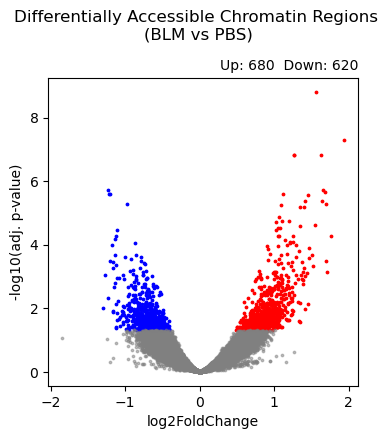

In [ ]:
up_index = (diff['log2FoldChange'] > 0 ) & (diff['padj'] < 0.05)
down_index = (diff['log2FoldChange'] < 0 ) & (diff['padj'] < 0.05)
none_index = (diff['padj'] >= 0.05)
diff['-log10(adj. p-value)'] = -1 * np.log10(diff['padj'])
plt.figure(figsize=(4, 4))
plt.scatter(diff.loc[up_index, 'log2FoldChange'], diff.loc[up_index, '-log10(adj. p-value)'], c='red', s=3)
plt.scatter(diff.loc[down_index, 'log2FoldChange'], diff.loc[down_index, '-log10(adj. p-value)'], c='blue', s=3)
plt.scatter(diff.loc[none_index, 'log2FoldChange'], diff.loc[none_index, '-log10(adj. p-value)'], c='grey', s=3, alpha=0.5)
plt.xlabel('log2FoldChange')
plt.ylabel('-log10(adj. p-value)')
up_count = up_index.value_counts().iloc[1]
down_count = down_index.value_counts().iloc[1]
plt.title(f'Up: {up_count:.0f}  Down: {down_count:.0f}', loc='right', fontsize=10)
plt.suptitle('Differentially Accessible Chromatin Regions \n(BLM vs PBS)', x=0.5, y=1.05, fontsize=12)
plt.savefig('../output/Figure1_BLM_vs_PBS_DE.pdf', bbox_inches='tight')


# 3.AnnotatePeak

## 3.1 Annotate

In [ ]:
counts_df = pd.read_csv("/mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/raw_count_peak.csv", index_col=0)
counts_df = counts_df.iloc[:, 0:4]

In [ ]:
counts_df.to_csv("/mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed", sep="\t", index=False, header=False)

In [ ]:
%%bash
annotatePeaks.pl /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed mm10 > /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info_annotated.txt


	Peak file = /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed
	Genome = mm10
	Organism = mouse
	Peak/BED file conversion summary:
		BED/Header formatted lines: 34276
		peakfile formatted lines: 0
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 34276
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding Closest TSS...
	Annotating:.........................
		Annotation	Number of peaks	Total size (bp)	Log2 Ratio (obs/exp)	LogP enrichment (+values depleted)
		3UTR	228.0	20765195	-0.197	3.952
		miRNA	6.0	31126	3.937	-12.538
		ncRNA	126.0	3444819	1.539	-54.820
		TTS	540.0	27318531	0.652	-51.281
		pseudo	13.0	551083	0.907	-3.677
		Exon	945.0	34641538	1.116	-229.711
		Intron	10019.0	950054350	-0.255	251.401
		Intergenic	

In [ ]:
diff_anno = pd.read_csv('/mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info_annotated.txt', sep='\t')
diff_anno

,PeakID (cmd=annotatePeaks.pl /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed mm10),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
0,T21-2A_FKDL190740162-1a_peak_13261l,chr1,88229308,88229807,+,0,NaN,"intron (NM_001281466, intron 3 of 41)",NaN,2537.0,NM_001281466,100040766.0,Mm.386915,NM_001177364,ENSMUSG00000079429,Mroh2a,Heatr7b1,maestro heat-like repeat family member 2A,protein-coding
1,T21-1A_FKDL190740161-1a_peak_15366b,chr1,105356470,105356969,+,0,NaN,promoter-TSS (NM_001160368),NaN,-9.0,NM_001160368,320311.0,Mm.389162,NM_178779,ENSMUSG00000047496,Rnf152,A930029B02Rik,ring finger protein 152,protein-coding
2,S21-2A_FKDL190740156-1a_peak_23962a,chr1,143739320,143739819,+,0,NaN,promoter-TSS (NM_023505),NaN,1.0,NM_001038592,69367.0,Mm.272727,NM_023505,ENSMUSG00000018196,Glrx2,1700010P22Rik|AI645710|Grx2,glutaredoxin 2 (thioltransferase),protein-coding
3,S21-2A_FKDL190740156-1a_peak_96847,chr11,119053220,119053719,+,0,NaN,Intergenic,NaN,-12556.0,NM_013926,30951.0,Mm.99953,NM_013926,ENSMUSG00000025578,Cbx8,Pc3,chromobox 8,protein-coding
4,S21-1A_FKDL190740155-1a_peak_17284k,chr1,88285200,88285699,+,0,NaN,Intergenic,NaN,-7870.0,NM_198652,381280.0,Mm.384762,NM_198652,ENSMUSG00000044783,Hjurp,6430706D22Rik|A730008H23Rik|C330011F01Rik|Gm97...,Holliday junction recognition protein,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34271,T21-3A_FKDL190740163-1a_peak_92758b,chr13,22042836,22043335,+,0,NaN,promoter-TSS (NM_178186),NaN,-113.0,NM_178198,319183.0,Mm.371766,NM_178198,ENSMUSG00000069300,Hist1h2bj,-,"histone cluster 1, H2bj",protein-coding
34272,S21-2A_FKDL190740156-1a_peak_59508a,chr10,127526613,127527112,+,0,NaN,"exon (NM_183297, exon 2 of 2)",NaN,-4418.0,NM_028230,108037.0,Mm.29890,NM_028230,ENSMUSG00000025403,Shmt2,2700043D08Rik|AA408223|AA986903|SHMT,serine hydroxymethyltransferase 2 (mitochondrial),protein-coding
34273,T21-1A_FKDL190740161-1a_peak_131740,chr13,107485604,107486103,+,0,NaN,Intergenic,NaN,16031.0,NR_045084,105120.0,Mm.417700,NR_045083,ENSMUSG00000114780,AI197445,-,expressed sequence AI197445,ncRNA
34274,T21-3A_FKDL190740163-1a_peak_5513d,chr1,58712482,58712981,+,0,NaN,promoter-TSS (NM_009805),NaN,-555.0,NM_207653,12633.0,Mm.336848,NM_009805,ENSMUSG00000026031,Cflar,2310024N18Rik|A430105C05Rik|CLARP|Cash|Casper|...,CASP8 and FADD-like apoptosis regulator,protein-coding


In [ ]:
print(diff_anno.shape)
diff_sub = diff_anno.dropna(subset='Annotation')
print(diff_sub.shape)
diff_sub.loc[:, 'Annotation'] = [i[0] for i in diff_sub['Annotation'].str.split(' \(')]
annotation_counts = diff_sub['Annotation'].value_counts()
annotation_counts

(34276, 19)
(34250, 19)


Annotation
promoter-TSS    14025
intron          10019
Intergenic       7448
5' UTR            893
exon              868
TTS               540
non-coding        229
3' UTR            228
Name: count, dtype: int64

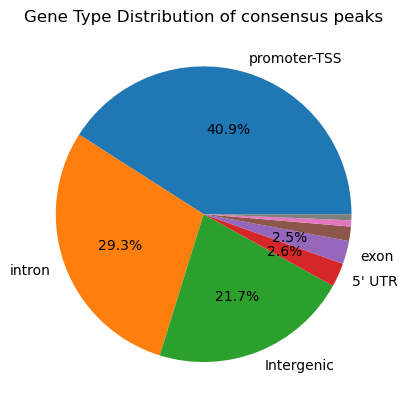

In [ ]:
fig, ax = plt.subplots()
wedges, labels, autopct = ax.pie(annotation_counts, labels=annotation_counts.index, autopct='%1.1f%%', pctdistance=0.6)

# Hide labels and percentages with a percentage less than 0.5
for label, pct in zip(labels, autopct):
    if float(pct.get_text().strip('%')) < 2:
        label.set_visible(False)
        pct.set_visible(False)

# Add title
ax.set_title('Gene Type Distribution of consensus peaks')

# Save the figure
plt.savefig('../output/pie_all_peak_bed.pdf', bbox_inches='tight')


## 3.2 Plot Annotate

### 3.2.1 Up regulated regions

In [ ]:
diff_index = diff.loc[(diff['padj'] < 0.05) & (diff['log2FoldChange'] > 0), :].index
diff_sub = diff_anno.loc[diff_anno.iloc[:,0].isin(diff_index),:]
print(diff_sub.shape)
diff_sub = diff_sub.dropna(subset='Annotation')
print(diff_sub.shape)
diff_sub['Annotation'] = [i[0] for i in diff_sub['Annotation'].str.split(' \(')]
diff_sub.to_csv('../output/up_regulated_diff_anno.csv', index=True, header=True)
annotation_counts = diff_sub['Annotation'].value_counts()
annotation_counts

(680, 19)
(680, 19)


Annotation
intron          313
Intergenic      276
promoter-TSS     60
3' UTR           11
5' UTR            8
exon              6
TTS               6
Name: count, dtype: int64

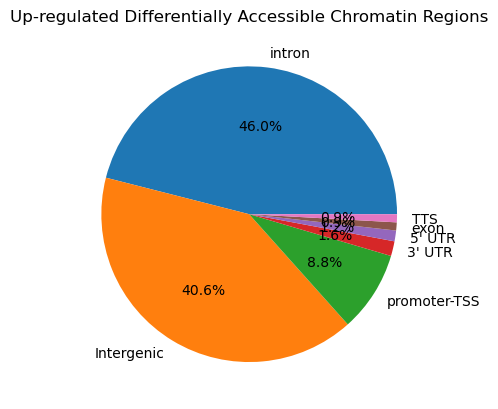

In [ ]:
# 创建饼图
fig, ax = plt.subplots()
ax.pie(annotation_counts, labels=annotation_counts.index, autopct='%1.1f%%', pctdistance=0.6)
# 添加标题
ax.set_title('Up-regulated Differentially Accessible Chromatin Regions')
# 显示图表
plt.savefig('../output/pie_up_regulated_diff_anno.pdf', bbox_inches='tight')

### 3.2.2 Down regulated regions

In [ ]:
diff_index = diff.loc[(diff['padj'] < 0.05) & (diff['log2FoldChange'] < 0), :].index
diff_sub = diff_anno.loc[diff_anno.iloc[:,0].isin(diff_index),:]
print(diff_sub.shape)
diff_sub = diff_sub.dropna(subset='Annotation')
print(diff_sub.shape)
diff_sub['Annotation'] = [i[0] for i in diff_sub['Annotation'].str.split(' \(')]
diff_sub.to_csv('../output/down_regulated_diff_anno.csv', index=True, header=True)
annotation_counts = diff_sub['Annotation'].value_counts()
annotation_counts

(620, 19)
(619, 19)


Annotation
promoter-TSS    336
Intergenic      127
intron          121
TTS              14
exon              8
5' UTR            8
3' UTR            5
Name: count, dtype: int64

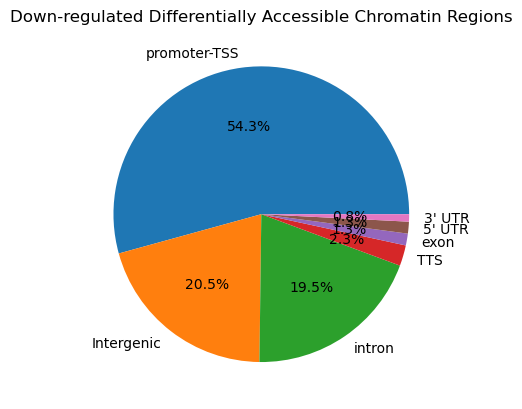

In [ ]:
# 创建饼图
fig, ax = plt.subplots()
ax.pie(annotation_counts, labels=annotation_counts.index, autopct='%1.1f%%')
# 添加标题
ax.set_title('Down-regulated Differentially Accessible Chromatin Regions')
# 显示图表
plt.savefig('../output/pie_dw_regulated_diff_anno.pdf', bbox_inches='tight')

### 3.2.3 all significant regions

In [ ]:
diff_index = diff.loc[diff['padj'] < 0.05, :].index
diff_sub = diff_anno.loc[diff_anno.iloc[:,0].isin(diff_index),:]
print(diff_sub.shape)
diff_sub = diff_sub.dropna(subset='Annotation')
print(diff_sub.shape)
diff_sub['Annotation'] = [i[0] for i in diff_sub['Annotation'].str.split(' \(')]
annotation_counts = diff_sub['Annotation'].value_counts()
annotation_counts

(1300, 19)
(1299, 19)


Annotation
intron          434
Intergenic      403
promoter-TSS    396
TTS              20
3' UTR           16
5' UTR           16
exon             14
Name: count, dtype: int64

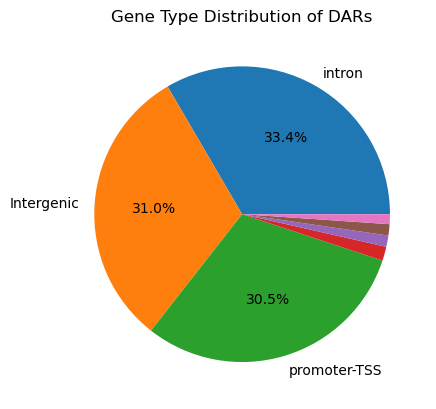

In [ ]:
fig, ax = plt.subplots()
wedges, labels, autopct = ax.pie(annotation_counts, labels=annotation_counts.index, autopct='%1.1f%%', pctdistance=0.6)

# Hide labels and percentages with a percentage less than 0.5
for label, pct in zip(labels, autopct):
    if float(pct.get_text().strip('%')) < 2:
        label.set_visible(False)
        pct.set_visible(False)

# Add title
ax.set_title('Gene Type Distribution of DARs')

# Save the figure
plt.savefig('../output/pie_all_regulated_diff_anno.pdf', bbox_inches='tight')

# 4.Findmotif in the genome

## 4.1 Up Region Motif

In [ ]:
data_dir = '/home/lzz/atac/output/up_regulated_diff_anno.csv'
save_dir = data_dir.replace('csv', 'tsv')
print(data_dir)
print(save_dir)

/home/lzz/atac/output/up_regulated_diff_anno.csv
/home/lzz/atac/output/up_regulated_diff_anno.tsv


In [ ]:
dat = pd.read_csv(data_dir, index_col=0)
dat

,PeakID (cmd=annotatePeaks.pl /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed mm10),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
17,B21-3A_FKDL190740160-1a_peak_164748b,chr14,31669753,31670252,+,0,NaN,Intergenic,NaN,28945.0,NM_025295,26363.0,Mm.282679,NM_025295,ENSMUSG00000021900,Btd,-,biotinidase,protein-coding
39,B21-1A_FKDL190740158-1a_peak_406022b,chr6,120077066,120077565,+,0,NaN,Intergenic,NaN,-16065.0,NM_016718,29862.0,Mm.103668,NM_016718,ENSMUSG00000041377,Ninj2,-,ninjurin 2,protein-coding
41,T21-2A_FKDL190740162-1a_peak_292672,chr2,148536453,148536952,+,0,NaN,Intergenic,NaN,-93167.0,NM_010740,17064.0,Mm.681,NM_010740,ENSMUSG00000027435,Cd93,6030404G09Rik|AA145088|AA4.1|AW555904|C1qr1|C1...,CD93 antigen,protein-coding
75,T21-3A_FKDL190740163-1a_peak_84721,chr12,99213176,99213675,+,0,NaN,intron,NaN,-50617.0,NR_038130,67639.0,Mm.87374,NR_038130,ENSMUSG00000113210,4930474N09Rik,-,RIKEN cDNA 4930474N09 gene,ncRNA
143,S21-3A_FKDL190740157-1a_peak_345439c,chr6,120082854,120083353,+,0,NaN,Intergenic,NaN,-10277.0,NM_016718,29862.0,Mm.103668,NM_016718,ENSMUSG00000041377,Ninj2,-,ninjurin 2,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34002,T21-1A_FKDL190740161-1a_peak_448235,chr8,57589151,57589650,+,0,NaN,intron,NaN,-62353.0,NR_040698,100502619.0,Mm.393851,NR_040698,NaN,AW046200,-,expressed sequence AW046200,ncRNA
34005,B21-3A_FKDL190740160-1a_peak_220692a,chr16,52060199,52060698,+,0,NaN,intron,NaN,28899.0,NM_001033238,208650.0,Mm.328206,NM_001033238,ENSMUSG00000022637,Cblb,AI429560|AI851073|Cbl-b,Casitas B-lineage lymphoma b,protein-coding
34013,T21-1A_FKDL190740161-1a_peak_464359b,chr8,122144730,122145229,+,0,NaN,Intergenic,NaN,-85295.0,NM_001362883,195209.0,Mm.102191,NM_001362883,NaN,Zfp469,Gm22,zinc finger protein 469,protein-coding
34202,T21-1A_FKDL190740161-1a_peak_481485a,chr9,64564307,64564806,+,0,NaN,intron,NaN,173200.0,NM_017382,53869.0,Mm.1387,NM_017382,ENSMUSG00000004771,Rab11a,-,"RAB11A, member RAS oncogene family",protein-coding


In [ ]:
dat.to_csv(save_dir, sep='\t', index=False, header=False)

In [ ]:
output_dir = data_dir.replace('.csv', '')
!echo $data_dir $output_dir
!findMotifsGenome.pl $save_dir mm10 $output_dir -mask -p 10 -size given -S 10

/home/lzz/atac/output/up_regulated_diff_anno.csv /home/lzz/atac/output/up_regulated_diff_anno

	Position file = /home/lzz/atac/output/up_regulated_diff_anno.tsv
	Genome = mm10
	Output Directory = /home/lzz/atac/output/up_regulated_diff_anno
	Will use repeat masked sequences
	Using 10 CPUs
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will optimize 10 putative motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 680

	Peak File Statistics:
		Total Peaks: 680
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 499 (avg size of targets)
ls: cannot access '/home/lzz/biotools/homer/.//data/genomes/mm10//preparsed//mm10r.*.cgbins': No 

## 4.2 Down Region Motif

In [ ]:
data_dir = '/home/lzz/atac/output/down_regulated_diff_anno.csv'
save_dir = data_dir.replace('csv', 'tsv')
print(data_dir)
print(save_dir)

/home/lzz/atac/output/down_regulated_diff_anno.csv
/home/lzz/atac/output/down_regulated_diff_anno.tsv


In [ ]:
dat = pd.read_csv(data_dir, index_col=0)
dat

,PeakID (cmd=annotatePeaks.pl /mnt/i/Suspended/ATAC-seq/mm10_t3_atac/Runtime/data/peak_info.bed mm10),Chr,Start,End,Strand,Peak Score,Focus Ratio/Region Size,Annotation,Detailed Annotation,Distance to TSS,Nearest PromoterID,Entrez ID,Nearest Unigene,Nearest Refseq,Nearest Ensembl,Gene Name,Gene Alias,Gene Description,Gene Type
16,S21-2A_FKDL190740156-1a_peak_112861,chr12,85818369,85818868,+,0,NaN,TTS (NM_001360813),NaN,6275.0,NM_001360451,58520.0,Mm.143795,NM_021446,ENSMUSG00000021252,Erg28,0610007P14Rik|1190004E09Rik|AU019315|C77855|ORF11,ergosterol biosynthesis 28,protein-coding
51,B21-1A_FKDL190740158-1a_peak_473156e,chr8,121084058,121084557,+,0,NaN,promoter-TSS (NM_010426),NaN,-79.0,NM_010426,15227.0,Mm.33897,NM_010426,ENSMUSG00000042812,Foxf1,AI450827|FREAC1|Foxf1a|Freac-1|HFH-8|Hfh8,forkhead box F1,protein-coding
118,T21-2A_FKDL190740162-1a_peak_416506d,chr6,72899613,72900112,+,0,NaN,promoter-TSS (NM_001347231),NaN,117.0,NM_019715,74287.0,Mm.29194,NM_019715,ENSMUSG00000055239,Kcmf1,1700094M07Rik|Debt91|Pmcf,potassium channel modulatory factor 1,protein-coding
254,S21-2A_FKDL190740156-1a_peak_269106b,chr2,14055831,14056330,+,0,NaN,promoter-TSS (NM_013935),NaN,-45.0,NM_001012396,30963.0,Mm.241205,NM_013935,ENSMUSG00000063275,Hacd1,Ptpla,3-hydroxyacyl-CoA dehydratase 1,protein-coding
303,S21-2A_FKDL190740156-1a_peak_206947,chr16,91597556,91598055,+,0,NaN,promoter-TSS (NM_030018),NaN,-125.0,NM_030018,77975.0,Mm.290341,NM_030018,ENSMUSG00000022964,Tmem50b,AU015466|AU019872|B230114J08Rik,transmembrane protein 50B,protein-coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34027,S21-2A_FKDL190740156-1a_peak_52221c,chr10,84533863,84534362,+,0,NaN,promoter-TSS (NM_175451),NaN,-224.0,NM_175451,216197.0,Mm.334999,NM_175451,ENSMUSG00000046841,Ckap4,5630400A09Rik|CLIMP-63|P63,cytoskeleton-associated protein 4,protein-coding
34085,B21-3A_FKDL190740160-1a_peak_463377b,chr6,90764076,90764575,+,0,NaN,"intron (NM_001356440, intron 1 of 13)",NaN,45798.0,NM_001134384,232227.0,Mm.196943,NM_182784,ENSMUSG00000034312,Iqsec1,AW561907|BC026481|BRAG2|D6Ertd349e|cI-43,IQ motif and Sec7 domain 1,protein-coding
34131,S21-1A_FKDL190740155-1a_peak_505050a,chr5,134541605,134542104,+,0,NaN,"intron (NM_001039162, intron 1 of 15)",NaN,10580.0,NM_001039162,269713.0,Mm.255138,NM_009990,ENSMUSG00000063146,Clip2,B230327O20|CLIP-115|Clip1|Cyln2|WSCR4|mKIAA029...,CAP-GLY domain containing linker protein 2,protein-coding
34146,T21-2A_FKDL190740162-1a_peak_286804b,chr2,119314861,119315360,+,0,NaN,Intergenic,NaN,-10674.0,NM_019454,54485.0,Mm.143719,NM_019454,ENSMUSG00000027314,Dll4,Delta4,delta like canonical Notch ligand 4,protein-coding


In [ ]:
dat.to_csv(save_dir, sep='\t', index=False, header=False)

In [ ]:
output_dir = data_dir.replace('.csv', '')
!echo $data_dir $output_dir
!findMotifsGenome.pl $save_dir mm10 $output_dir -mask -p 10 -size given -S 10

/home/lzz/atac/output/down_regulated_diff_anno.csv /home/lzz/atac/output/down_regulated_diff_anno

	Position file = /home/lzz/atac/output/down_regulated_diff_anno.tsv
	Genome = mm10
	Output Directory = /home/lzz/atac/output/down_regulated_diff_anno
	Will use repeat masked sequences
	Using 10 CPUs
	Using actual sizes of regions (-size given)
	Fragment size set to given
	Will optimize 10 putative motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 619

	Peak File Statistics:
		Total Peaks: 619
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background fragment size set to 499 (avg size of targets)
	Background files for 499 bp fragments found.
	Custom genome sequence directory: /home/lz

# 5.TSS Score barplot

In [ ]:
dat = pd.DataFrame({
    'Group': ['PBS'] * 3 + ['BLM'] * 3,
    'TSS': [7.9, 12.8, 9.6, 7.1, 10.4, 9.2]
})
dat

,Group,TSS
0,PBS,7.9
1,PBS,12.8
2,PBS,9.6
3,BLM,7.1
4,BLM,10.4
5,BLM,9.2


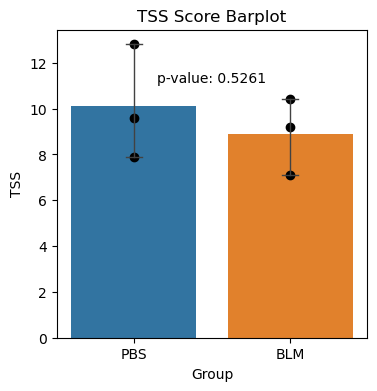

In [ ]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# 进行t检验
t_statistic, p_value = stats.ttest_ind(dat.loc[dat['Group'] == 'PBS', 'TSS'], dat.loc[dat['Group'] == 'BLM', 'TSS'],)
# Plot the barplot
plt.figure(figsize=(4, 4))
sns.barplot(x='Group', y='TSS', data=dat, capsize=0.1, errwidth=1)

# Add text with p-value
plt.text(0.5, 11, f"p-value: {p_value:.4f}", ha='center', va='bottom')

# Add a point
plt.scatter(x='Group', y='TSS', data=dat, color='black', marker='o')

# Set labels and title
plt.xlabel('Group')
plt.ylabel('TSS')
plt.title('TSS Score Barplot')

# Show the plot
plt.show()
